### 1 Fit Baseline Model

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.model_selection import GridSearchCV
import pandas as pd
import os
import dtale
import numpy as np

Load in dataset

In [30]:
project_dir = os.path.dirname(os.path.abspath(''))
df = pd.read_json(os.path.join(project_dir, 'model_prepped_dataset.json'))
dtale.show(df).open_browser()

Assign dataset to X matrix and y vector and apply any necessary transformations.

In [111]:
X = df.loc[:, df.columns != 'Outcome']
X['Match_Relevance'] = 1 / (X['Match_Relevance'] ** 2)
X = X.drop(['Day', 'Home_Team_Home_Streak', 'Away_Team_Away_Streak'], axis=1)
y = df['Outcome']

In [112]:
X.tail()

,Season,Capacity,Elo_home,Elo_away,Home_Team_Streak,Away_Team_Streak,Home_Team_Form,Away_Team_Form,Home_Team_Home_Form,Away_Team_Away_Form,Home_Team_Goals,Away_Team_Goals,Home_Team_Home_Goals,Away_Team_Away_Goals,Match_Relevance
105459,2021,41841,90,91,0,1,4,2,1,2,1.1,2.2,1.9,1.8,0.000007
105460,2021,62062,89,73,0,0,-3,0,0,-1,1.2,0.9,1.6,0.5,0.000007
105461,2021,32500,84,89,2,0,2,-2,2,1,1.6,1.6,1.5,1.1,0.000007
105462,2021,18482,60,72,3,0,1,-1,-1,-1,1.2,0.8,0.8,1.2,0.000007
105463,2021,21628,70,74,0,3,0,2,2,-1,1.1,1.6,1.1,1.4,0.000007


Split into training set and test set.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(X))

83509
14738
98247


Scale X by standardising it. Use the mean and standard deviation of the training set to standardise the test set.

In [114]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#### Option 1) Logistic Regression

Train model.

In [115]:
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

LogisticRegression()

Test the accuracy of the model by checking against the test set. This consists of calculating the MSE and accuracy of the predicted classification.

In [116]:
y_pred_log = lgr.predict(X_test)
mse_log = mean_squared_error(y_test, y_pred_log)
accu_log = accuracy_score(y_test, y_pred_log) * 100
print(f'Logistic Regression Model\nAccuracy: {accu_log:.2f}%.\nMSE: {mse_log:.2f}')
print(r2_score(y_test, y_pred_log))

Logistic Regression Model
Accuracy: 49.81%.
MSE: 1.16
-0.7188287314131472


#### Option 2) Linear Regression

Train model.

In [37]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Test the accuracy of the model by checking against the test set. This consists of calculating the MSE and accuracy of the predicted outcome.

In [38]:
y_pred_lin = np.rint(lr.predict(X_test))
mse_lin = mean_squared_error(y_test, y_pred_lin)
accu_lin = accuracy_score(y_test, y_pred_lin) * 100
print(f'Linear Regression Model\nAccuracy: {accu_lin:.2f}%.\nMSE: {mse_lin:.2f}')

Linear Regression Model
Accuracy: 34.46%.
MSE: 0.69


**Conclusion:** Baseline model is simple logistic regression with 49.75% accuracy.

### 2 Feature Selection

Look at feature heatmap to understand correlations between features better.

<AxesSubplot:>

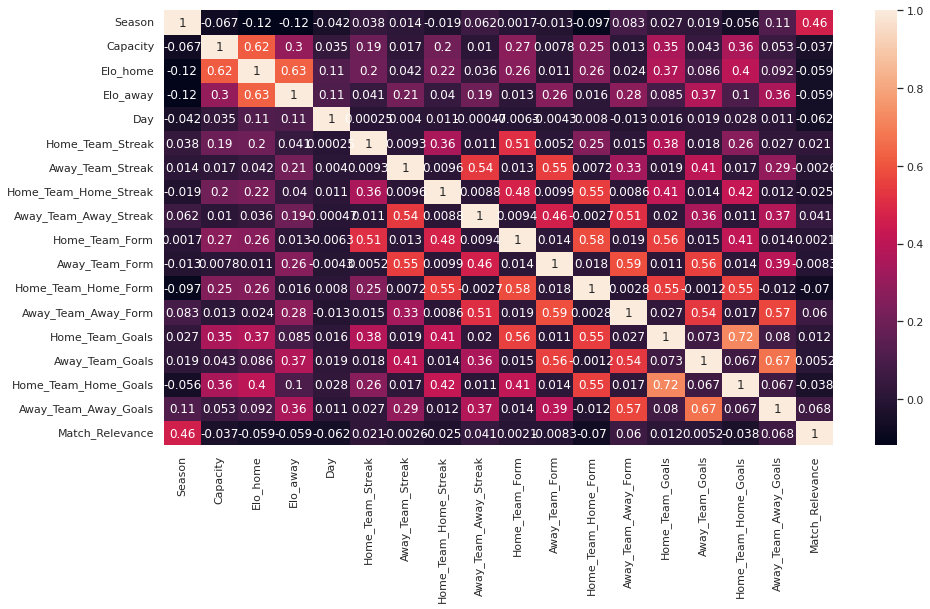

In [39]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr(), annot=True)

Carry out lasso regression to understand feature importance.

In [117]:
ls = Lasso()
ls.fit(X_train, y_train)
search = GridSearchCV(ls, {'alpha': np.arange(0.01, 0.1, 0.01)}, cv=5, scoring="neg_mean_squared_error", verbose=3)
search.fit(X_train, y_train)
print(search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END .......................alpha=0.01;, score=-0.619 total time=   0.2s
[CV 2/5] END .......................alpha=0.01;, score=-0.614 total time=   0.3s
[CV 3/5] END .......................alpha=0.01;, score=-0.625 total time=   0.3s
[CV 4/5] END .......................alpha=0.01;, score=-0.620 total time=   0.3s
[CV 5/5] END .......................alpha=0.01;, score=-0.622 total time=   0.2s
[CV 1/5] END .......................alpha=0.02;, score=-0.622 total time=   0.3s
[CV 2/5] END .......................alpha=0.02;, score=-0.616 total time=   0.2s
[CV 3/5] END .......................alpha=0.02;, score=-0.628 total time=   0.3s
[CV 4/5] END .......................alpha=0.02;, score=-0.622 total time=   0.2s
[CV 5/5] END .......................alpha=0.02;, score=-0.624 total time=   0.2s
[CV 1/5] END .......................alpha=0.03;, score=-0.625 total time=   0.2s
[CV 2/5] END .......................alpha=0.03;, 

https://medium.com/@sabarirajan.kumarappan/feature-selection-by-lasso-and-ridge-regression-python-code-examples-1e8ab451b94b


https://machinelearninghd.com/lasso-regression-in-python/

In [118]:
print(search.best_estimator_)
print(abs(search.best_estimator_.coef_))
np.array(list(X))[abs(search.best_estimator_.coef_) == 0]

Lasso(alpha=0.01)
[0.01790564 0.03001954 0.14848053 0.17167704 0.00519283 0.00665246
 0.02661415 0.02032185 0.01165504 0.0126546  0.00801533 0.02876192
 0.03583178 0.03355467 0.00415391]


array([], dtype='<U20')